# Notebook 02: Preprocessing and Feature Engineering

Learn how to prepare data for machine learning models.

## Learning Objectives
- Apply different scaling techniques
- Encode categorical variables
- Perform feature selection
- Create train/test/validation splits
- Build preprocessing pipelines

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification, load_iris, fetch_california_housing
from sklearn.preprocessing import (
    StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler,
    LabelEncoder, OneHotEncoder, OrdinalEncoder
)
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_selection import (
    SelectKBest, f_classif, mutual_info_classif,
    RFE, SelectFromModel
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier

np.random.seed(42)
plt.style.use('seaborn-v0_8-whitegrid')

## Part 1: Feature Scaling

Different scaling methods and when to use them.

In [2]:
# Create data with different scales and outliers
n_samples = 500

# Feature 1: Normal distribution
f1 = np.random.randn(n_samples) * 10 + 50

# Feature 2: Uniform distribution with different scale
f2 = np.random.uniform(0, 1000, n_samples)

# Feature 3: With outliers
f3 = np.random.randn(n_samples) * 5
f3[np.random.choice(n_samples, 20)] = np.random.uniform(50, 100, 20)  # Add outliers

X = np.column_stack([f1, f2, f3])

print("Original data statistics:")
print(f"Feature 1 - Mean: {f1.mean():.2f}, Std: {f1.std():.2f}, Range: [{f1.min():.2f}, {f1.max():.2f}]")
print(f"Feature 2 - Mean: {f2.mean():.2f}, Std: {f2.std():.2f}, Range: [{f2.min():.2f}, {f2.max():.2f}]")
print(f"Feature 3 - Mean: {f3.mean():.2f}, Std: {f3.std():.2f}, Range: [{f3.min():.2f}, {f3.max():.2f}]")

Original data statistics:
Feature 1 - Mean: 50.07, Std: 9.80, Range: [17.59, 88.53]
Feature 2 - Mean: 500.95, Std: 290.58, Range: [4.63, 997.93]
Feature 3 - Mean: 3.15, Std: 15.05, Range: [-14.48, 98.39]


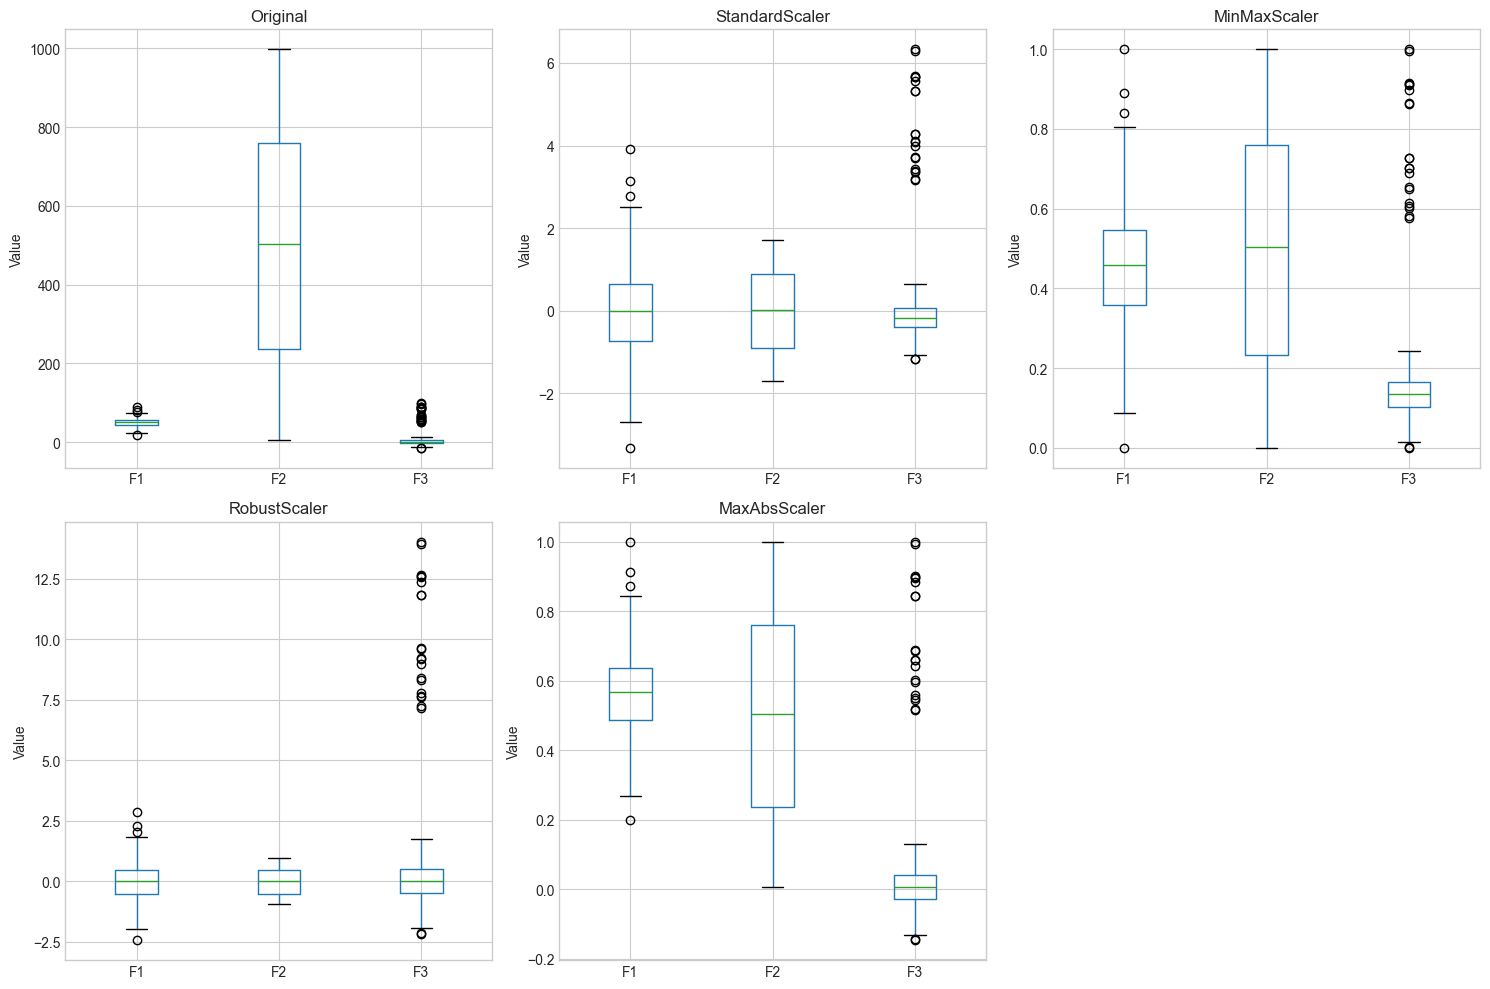

In [3]:
# Apply different scalers
scalers = {
    'Original': None,
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler(),
    'MaxAbsScaler': MaxAbsScaler()
}

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, (name, scaler) in enumerate(scalers.items()):
    if scaler is None:
        X_scaled = X.copy()
    else:
        X_scaled = scaler.fit_transform(X)
    
    # Box plot of scaled features
    df_scaled = pd.DataFrame(X_scaled, columns=['F1', 'F2', 'F3'])
    df_scaled.boxplot(ax=axes[idx])
    axes[idx].set_title(f'{name}')
    axes[idx].set_ylabel('Value')

# Remove empty subplot
axes[-1].axis('off')

plt.tight_layout()
plt.show()

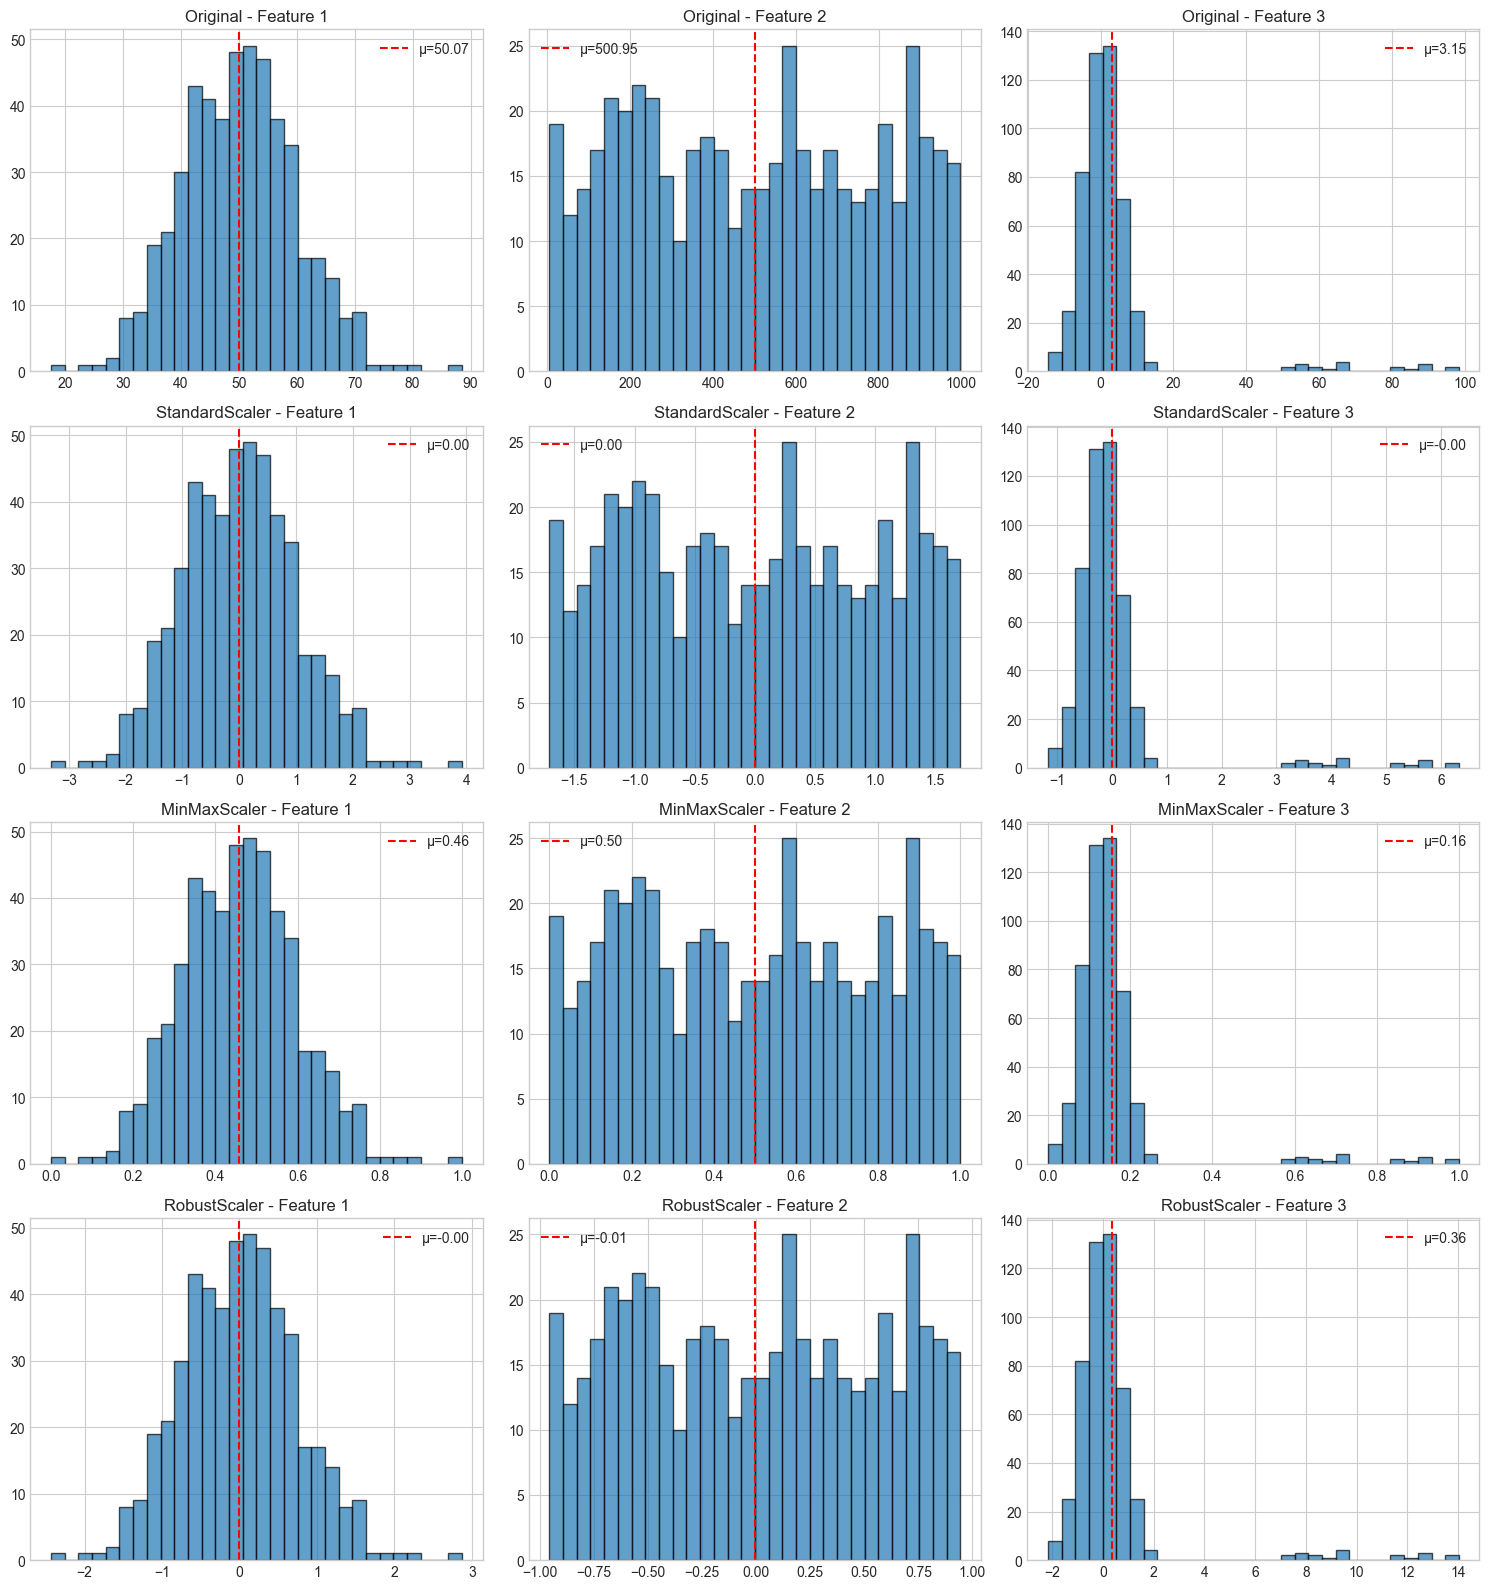

In [4]:
# Detailed comparison: Distribution before and after scaling
fig, axes = plt.subplots(4, 3, figsize=(15, 16))

scalers_to_compare = [
    ('Original', None),
    ('StandardScaler', StandardScaler()),
    ('MinMaxScaler', MinMaxScaler()),
    ('RobustScaler', RobustScaler())
]

for row, (name, scaler) in enumerate(scalers_to_compare):
    if scaler is None:
        X_scaled = X.copy()
    else:
        X_scaled = scaler.fit_transform(X)
    
    for col in range(3):
        axes[row, col].hist(X_scaled[:, col], bins=30, edgecolor='black', alpha=0.7)
        axes[row, col].set_title(f'{name} - Feature {col+1}')
        
        # Add statistics
        mean_val = X_scaled[:, col].mean()
        std_val = X_scaled[:, col].std()
        axes[row, col].axvline(mean_val, color='red', linestyle='--', label=f'μ={mean_val:.2f}')
        axes[row, col].legend()

plt.tight_layout()
plt.show()

### Scaler Comparison Summary

| Scaler | Formula | Best For |
|--------|---------|----------|
| StandardScaler | (x - μ) / σ | Normally distributed data |
| MinMaxScaler | (x - min) / (max - min) | Bounded features, neural networks |
| RobustScaler | (x - median) / IQR | Data with outliers |
| MaxAbsScaler | x / max(abs(x)) | Sparse data |

## Part 2: Encoding Categorical Variables

In [5]:
# Create sample data with categorical variables
data = pd.DataFrame({
    'color': np.random.choice(['red', 'green', 'blue'], 100),
    'size': np.random.choice(['small', 'medium', 'large'], 100),
    'price': np.random.uniform(10, 100, 100)
})

print("Original data:")
print(data.head(10))

Original data:
   color    size      price
0    red  medium  60.899497
1   blue   small  98.168204
2  green   small  24.876470
3  green   small  73.022676
4    red  medium  62.722913
5    red  medium  62.783118
6   blue  medium  72.790356
7  green  medium  93.665523
8   blue  medium  80.432375
9  green   small  15.052249


In [6]:
# Label Encoding (for ordinal data)
le = LabelEncoder()
data['size_encoded'] = le.fit_transform(data['size'])

print("Label Encoding for 'size':")
print(f"Classes: {le.classes_}")
print(f"Encoded values: {np.unique(data['size_encoded'])}")
print(data[['size', 'size_encoded']].drop_duplicates())

Label Encoding for 'size':
Classes: ['large' 'medium' 'small']
Encoded values: [0 1 2]
      size  size_encoded
0   medium             1
1    small             2
16   large             0


In [7]:
# One-Hot Encoding (for nominal data)
ohe = OneHotEncoder(sparse_output=False)
color_encoded = ohe.fit_transform(data[['color']])

print("\nOne-Hot Encoding for 'color':")
print(f"Categories: {ohe.categories_}")
color_df = pd.DataFrame(
    color_encoded, 
    columns=[f'color_{cat}' for cat in ohe.categories_[0]]
)
print(pd.concat([data[['color']], color_df], axis=1).head(10))


One-Hot Encoding for 'color':
Categories: [array(['blue', 'green', 'red'], dtype=object)]
   color  color_blue  color_green  color_red
0    red         0.0          0.0        1.0
1   blue         1.0          0.0        0.0
2  green         0.0          1.0        0.0
3  green         0.0          1.0        0.0
4    red         0.0          0.0        1.0
5    red         0.0          0.0        1.0
6   blue         1.0          0.0        0.0
7  green         0.0          1.0        0.0
8   blue         1.0          0.0        0.0
9  green         0.0          1.0        0.0


In [8]:
# Ordinal Encoding with custom order
oe = OrdinalEncoder(categories=[['small', 'medium', 'large']])
data['size_ordinal'] = oe.fit_transform(data[['size']])

print("\nOrdinal Encoding with custom order:")
print(data[['size', 'size_ordinal']].drop_duplicates().sort_values('size_ordinal'))


Ordinal Encoding with custom order:
      size  size_ordinal
1    small           0.0
0   medium           1.0
16   large           2.0


## Part 3: Train/Test/Validation Splits

In [9]:
# Generate classification data
X, y = make_classification(n_samples=1000, n_features=20, n_classes=3, 
                          n_informative=10, random_state=42)

print(f"Total samples: {len(y)}")
print(f"Class distribution: {np.bincount(y)}")

Total samples: 1000
Class distribution: [336 332 332]


In [10]:
# Simple train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Simple Train/Test Split:")
print(f"Training set: {len(y_train)} samples")
print(f"Test set: {len(y_test)} samples")
print(f"\nTraining class distribution: {np.bincount(y_train)}")
print(f"Test class distribution: {np.bincount(y_test)}")

Simple Train/Test Split:
Training set: 800 samples
Test set: 200 samples

Training class distribution: [269 265 266]
Test class distribution: [67 67 66]


In [11]:
# Train/Validation/Test split (60/20/20)
# First split: separate test set
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Second split: separate validation from training
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp  # 0.25 of 0.8 = 0.2
)

print("Train/Validation/Test Split:")
print(f"Training set: {len(y_train)} samples ({len(y_train)/len(y)*100:.0f}%)")
print(f"Validation set: {len(y_val)} samples ({len(y_val)/len(y)*100:.0f}%)")
print(f"Test set: {len(y_test)} samples ({len(y_test)/len(y)*100:.0f}%)")

Train/Validation/Test Split:
Training set: 600 samples (60%)
Validation set: 200 samples (20%)
Test set: 200 samples (20%)


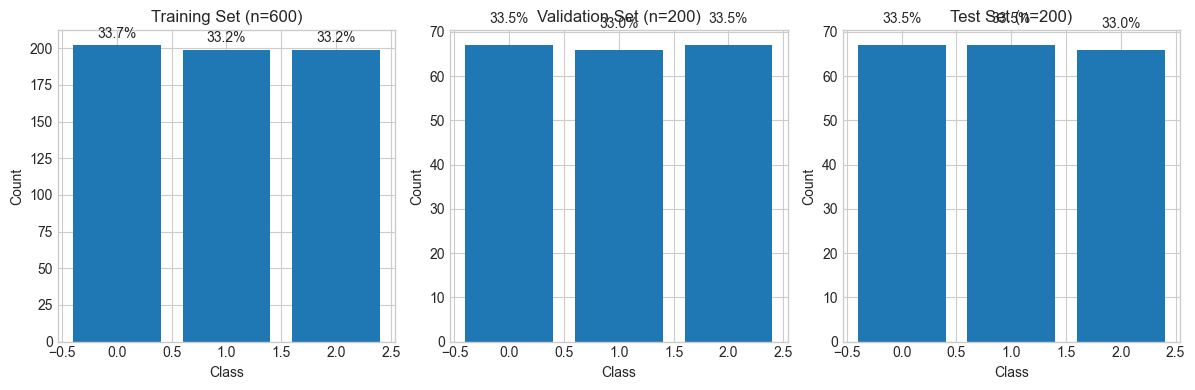

In [12]:
# Visualize stratification
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

sets = [('Training', y_train), ('Validation', y_val), ('Test', y_test)]

for idx, (name, labels) in enumerate(sets):
    counts = np.bincount(labels)
    axes[idx].bar(range(len(counts)), counts)
    axes[idx].set_title(f'{name} Set (n={len(labels)})')
    axes[idx].set_xlabel('Class')
    axes[idx].set_ylabel('Count')
    
    # Add percentage labels
    for i, count in enumerate(counts):
        axes[idx].text(i, count + 5, f'{count/len(labels)*100:.1f}%', ha='center')

plt.tight_layout()
plt.show()

## Part 4: Cross-Validation

In [13]:
# Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Stratified 5-Fold Cross-Validation:")
print("="*50)

fold_info = []
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    train_dist = np.bincount(y[train_idx])
    val_dist = np.bincount(y[val_idx])
    
    print(f"\nFold {fold}:")
    print(f"  Train size: {len(train_idx)}, distribution: {train_dist}")
    print(f"  Val size: {len(val_idx)}, distribution: {val_dist}")
    
    fold_info.append({
        'fold': fold,
        'train_size': len(train_idx),
        'val_size': len(val_idx)
    })

Stratified 5-Fold Cross-Validation:

Fold 1:
  Train size: 800, distribution: [268 266 266]
  Val size: 200, distribution: [68 66 66]

Fold 2:
  Train size: 800, distribution: [269 266 265]
  Val size: 200, distribution: [67 66 67]

Fold 3:
  Train size: 800, distribution: [269 266 265]
  Val size: 200, distribution: [67 66 67]

Fold 4:
  Train size: 800, distribution: [269 265 266]
  Val size: 200, distribution: [67 67 66]

Fold 5:
  Train size: 800, distribution: [269 265 266]
  Val size: 200, distribution: [67 67 66]


## Part 5: Feature Selection

In [14]:
# Generate data with informative and redundant features
X, y = make_classification(
    n_samples=500,
    n_features=20,
    n_informative=5,
    n_redundant=5,
    n_classes=2,
    random_state=42
)

print(f"Total features: {X.shape[1]}")
print(f"Informative features: 5")
print(f"Redundant features: 5")
print(f"Random features: 10")

Total features: 20
Informative features: 5
Redundant features: 5
Random features: 10


In [15]:
# Method 1: SelectKBest with ANOVA F-test
selector_f = SelectKBest(score_func=f_classif, k=10)
X_selected_f = selector_f.fit_transform(X, y)

# Get scores and selected features
scores_f = selector_f.scores_
selected_f = selector_f.get_support(indices=True)

print("SelectKBest (F-test) - Top 10 features:")
print(f"Selected features: {selected_f}")

# Method 2: SelectKBest with Mutual Information
selector_mi = SelectKBest(score_func=mutual_info_classif, k=10)
X_selected_mi = selector_mi.fit_transform(X, y)

scores_mi = selector_mi.scores_
selected_mi = selector_mi.get_support(indices=True)

print(f"\nSelectKBest (Mutual Info) - Top 10 features:")
print(f"Selected features: {selected_mi}")

SelectKBest (F-test) - Top 10 features:
Selected features: [ 0  1  4  7  8  9 11 13 14 19]

SelectKBest (Mutual Info) - Top 10 features:
Selected features: [ 0  1  7  8  9 11 12 13 14 19]


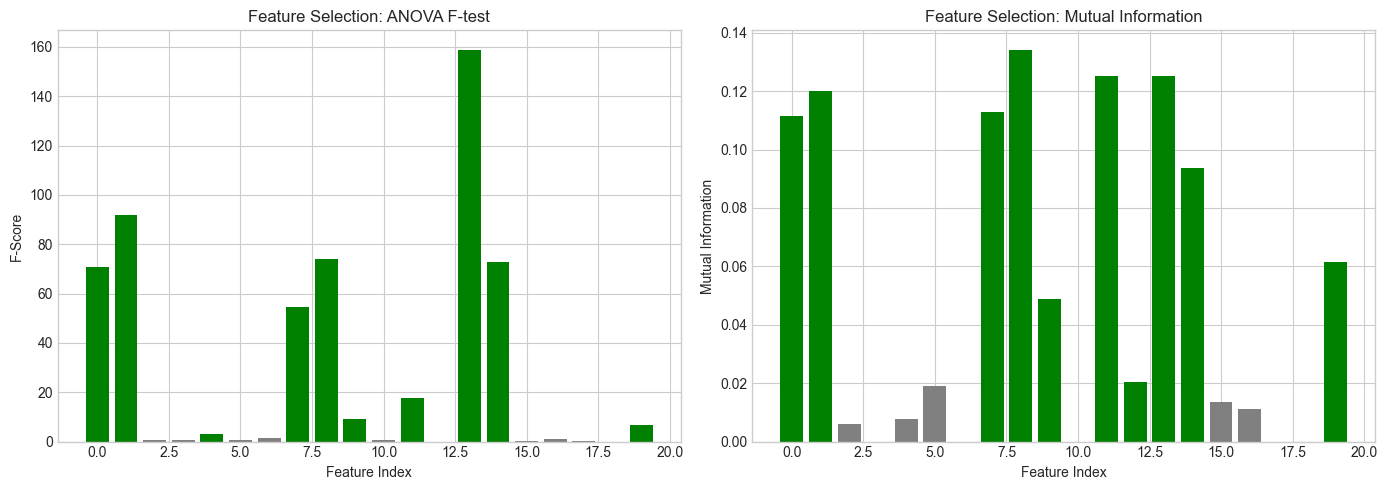

In [16]:
# Visualize feature scores
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# F-test scores
feature_idx = np.arange(len(scores_f))
colors = ['green' if i in selected_f else 'gray' for i in feature_idx]
axes[0].bar(feature_idx, scores_f, color=colors)
axes[0].set_xlabel('Feature Index')
axes[0].set_ylabel('F-Score')
axes[0].set_title('Feature Selection: ANOVA F-test')

# Mutual Information scores
colors = ['green' if i in selected_mi else 'gray' for i in feature_idx]
axes[1].bar(feature_idx, scores_mi, color=colors)
axes[1].set_xlabel('Feature Index')
axes[1].set_ylabel('Mutual Information')
axes[1].set_title('Feature Selection: Mutual Information')

plt.tight_layout()
plt.show()

Recursive Feature Elimination (RFE) - Top 10 features:
Selected features: [ 0  1  4  5  6  7  8  9 13 14]


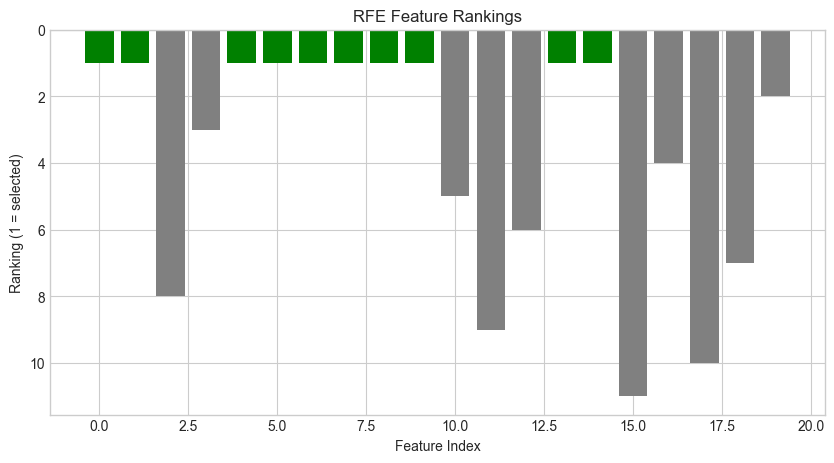

In [17]:
# Method 3: Recursive Feature Elimination (RFE)
from sklearn.linear_model import LogisticRegression

estimator = LogisticRegression(max_iter=1000, random_state=42)
rfe = RFE(estimator, n_features_to_select=10, step=1)
X_selected_rfe = rfe.fit_transform(X, y)

selected_rfe = np.where(rfe.support_)[0]
rankings_rfe = rfe.ranking_

print("Recursive Feature Elimination (RFE) - Top 10 features:")
print(f"Selected features: {selected_rfe}")

# Visualize RFE rankings
plt.figure(figsize=(10, 5))
colors = ['green' if rank == 1 else 'gray' for rank in rankings_rfe]
plt.bar(feature_idx, rankings_rfe, color=colors)
plt.xlabel('Feature Index')
plt.ylabel('Ranking (1 = selected)')
plt.title('RFE Feature Rankings')
plt.gca().invert_yaxis()
plt.show()

Random Forest Feature Importances:
Top 10 features:
  Feature 14: 0.1485
  Feature 8: 0.1062
  Feature 7: 0.1020
  Feature 11: 0.0977
  Feature 13: 0.0857
  Feature 1: 0.0836
  Feature 19: 0.0673
  Feature 0: 0.0583
  Feature 5: 0.0562
  Feature 9: 0.0503


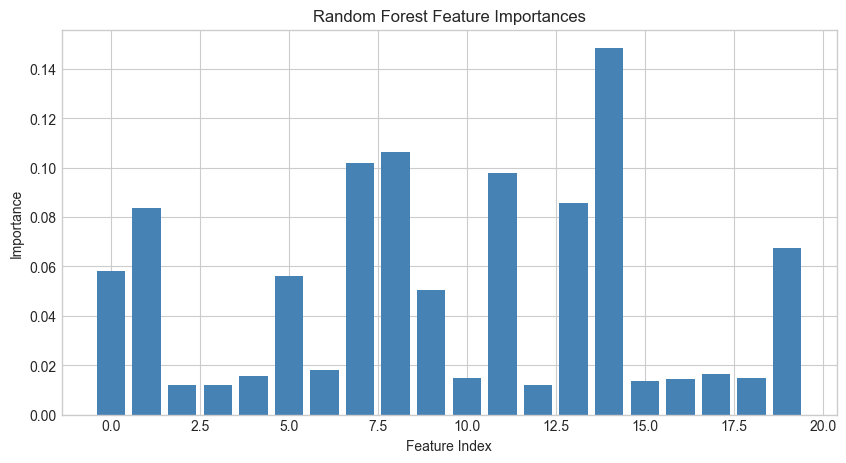

In [18]:
# Method 4: Feature importance from Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

print("Random Forest Feature Importances:")
print("Top 10 features:")
for i in range(10):
    print(f"  Feature {indices[i]}: {importances[indices[i]]:.4f}")

# Visualize
plt.figure(figsize=(10, 5))
plt.bar(feature_idx, importances, color='steelblue')
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.title('Random Forest Feature Importances')
plt.show()

## Part 6: Building Preprocessing Pipelines

In [19]:
# Create a complete preprocessing pipeline
from sklearn.impute import SimpleImputer

# Generate sample data with mixed types
np.random.seed(42)
n = 200

# Numeric features
numeric_data = np.random.randn(n, 3) * np.array([10, 100, 1000])
# Add some missing values
numeric_data[np.random.choice(n, 20), 0] = np.nan

# Categorical features
cat_data = np.random.choice(['A', 'B', 'C'], (n, 2))

# Create DataFrame
df = pd.DataFrame(
    numeric_data, 
    columns=['num_1', 'num_2', 'num_3']
)
df['cat_1'] = cat_data[:, 0]
df['cat_2'] = cat_data[:, 1]

# Target
y = np.random.randint(0, 2, n)

print("Sample data:")
print(df.head())
print(f"\nMissing values: {df.isna().sum().sum()}")

Sample data:
       num_1       num_2        num_3 cat_1 cat_2
0   4.967142  -13.826430   647.688538     C     C
1  15.230299  -23.415337  -234.136957     B     B
2  15.792128   76.743473  -469.474386     C     B
3   5.425600  -46.341769  -465.729754     A     B
4   2.419623 -191.328024 -1724.917833     B     A

Missing values: 20


In [20]:
# Define preprocessing for numeric and categorical features
numeric_features = ['num_1', 'num_2', 'num_3']
categorical_features = ['cat_1', 'cat_2']

# Numeric pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical pipeline
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Fit and transform
X_processed = preprocessor.fit_transform(df)

print(f"Original shape: {df.shape}")
print(f"Processed shape: {X_processed.shape}")
print(f"\nFeature names after preprocessing:")

# Get feature names
cat_features = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)
all_features = list(numeric_features) + list(cat_features)
print(all_features)

Original shape: (200, 5)
Processed shape: (200, 9)

Feature names after preprocessing:
['num_1', 'num_2', 'num_3', 'cat_1_A', 'cat_1_B', 'cat_1_C', 'cat_2_A', 'cat_2_B', 'cat_2_C']


In [21]:
# Complete pipeline with model
from sklearn.neural_network import MLPClassifier

# Create full pipeline
full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', MLPClassifier(hidden_layer_sizes=(50,), max_iter=500, random_state=42))
])

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    df, y, test_size=0.2, random_state=42
)

# Fit pipeline
full_pipeline.fit(X_train, y_train)

# Evaluate
train_score = full_pipeline.score(X_train, y_train)
test_score = full_pipeline.score(X_test, y_test)

print(f"Training accuracy: {train_score:.4f}")
print(f"Test accuracy: {test_score:.4f}")

Training accuracy: 0.8187
Test accuracy: 0.5750


/Users/ikmx/source/personal/machine-learning-playground/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


## Part 7: Practical Example - Complete Workflow

In [22]:
# Load real dataset
iris = load_iris()
X_iris = iris.data
y_iris = iris.target

print("Iris Dataset:")
print(f"Features: {iris.feature_names}")
print(f"Classes: {iris.target_names}")
print(f"Shape: {X_iris.shape}")

Iris Dataset:
Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Classes: ['setosa' 'versicolor' 'virginica']
Shape: (150, 4)


In [23]:
# Complete preprocessing workflow

# 1. Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_iris, y_iris, test_size=0.2, random_state=42, stratify=y_iris
)

# 2. Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit on training data only!
X_test_scaled = scaler.transform(X_test)  # Transform test data

# 3. Feature selection
selector = SelectKBest(score_func=f_classif, k=3)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

selected_features = np.array(iris.feature_names)[selector.get_support()]

print("Preprocessing Complete:")
print(f"Original features: {len(iris.feature_names)}")
print(f"Selected features: {selected_features}")
print(f"Training shape: {X_train_selected.shape}")
print(f"Test shape: {X_test_selected.shape}")

Preprocessing Complete:
Original features: 4
Selected features: ['sepal length (cm)' 'petal length (cm)' 'petal width (cm)']
Training shape: (120, 3)
Test shape: (30, 3)


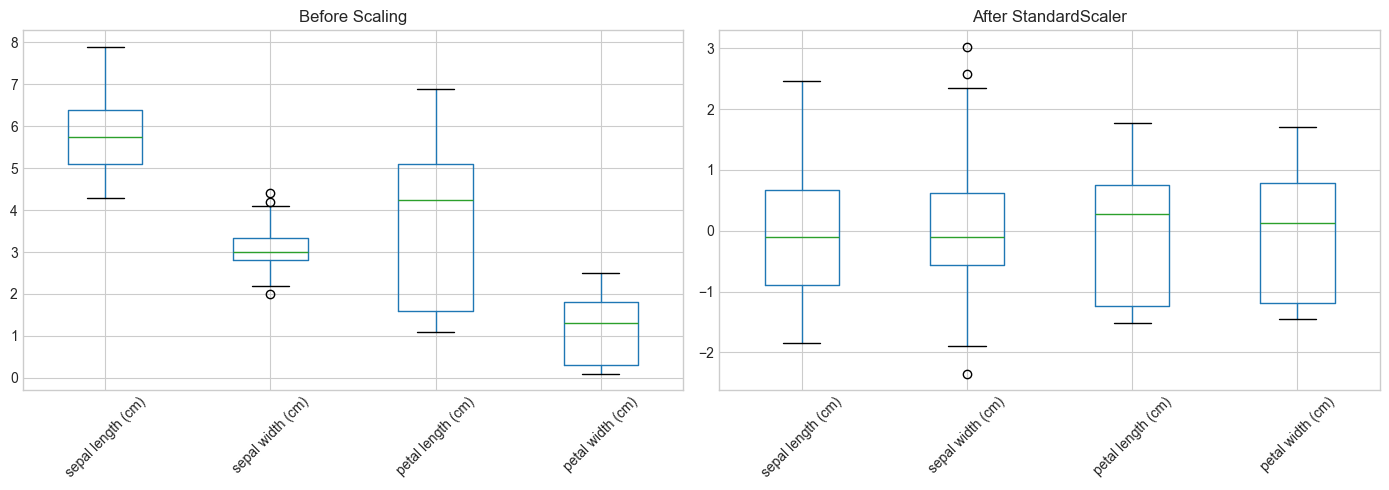

In [24]:
# Visualize scaling effect
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before scaling
df_before = pd.DataFrame(X_train, columns=iris.feature_names)
df_before.boxplot(ax=axes[0])
axes[0].set_title('Before Scaling')
axes[0].tick_params(axis='x', rotation=45)

# After scaling
df_after = pd.DataFrame(X_train_scaled, columns=iris.feature_names)
df_after.boxplot(ax=axes[1])
axes[1].set_title('After StandardScaler')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Summary

In this notebook, you learned:

1. **Feature Scaling**: StandardScaler, MinMaxScaler, RobustScaler
2. **Encoding**: LabelEncoder, OneHotEncoder, OrdinalEncoder
3. **Data Splits**: Train/test, train/val/test, stratified splitting
4. **Cross-Validation**: StratifiedKFold
5. **Feature Selection**: SelectKBest, RFE, feature importance
6. **Pipelines**: Combining preprocessing steps with ColumnTransformer

### Key Takeaways
- Always fit scalers/encoders on training data only
- Use stratified splits for imbalanced classes
- Pipelines ensure consistent preprocessing
- Feature selection can improve model performance and interpretability

### Next Steps
Continue to **Notebook 03** to learn about model evaluation metrics.